# Image to Image Translation using Conditional GAN

URL : https://www.tensorflow.org/tutorials/generative/pix2pix?hl=fr

### Importer les bibliothèques

In [1]:
%pip install tensorflow
%pip install --upgrade tensorflow matplotlib ipython

import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


2024-12-11 09:54:49.942822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733907290.059474     920 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733907290.090859     920 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 09:54:50.365853: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Charger le jeu de données

Lien : https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/

Télécharger facades.tar.gz

In [2]:
#%tar -xvf facades.tar.gz

dataset_name = "facades"

sample_image = tf.io.read_file(dataset_name+"/train/1.jpg")
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)


(256, 512, 3)


I0000 00:00:1733907294.519806     920 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


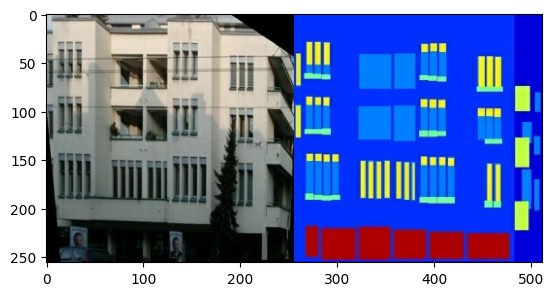

In [3]:
plt.figure()
plt.imshow(sample_image)

In [4]:
# Charge l'image d'entrée et l'image réelle séparément
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

inp, re = load(dataset_name+"/train/1.jpg")

plt.figure()
plt.imshow(inp / 255)
plt.figure()
plt.imshow(re / 255)


In [5]:
BUFFER_SIZE = 400 # Nombre d'images dans l'ensemble d'entrainement
BATCH_SIZE = 1

IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
def resize(input_image,real_image,height,width):
    input_image = tf.image.resize(input_image, [height,width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image,real_image

In [7]:
def random_crop(input_image,real_image):
    # Superposition des 2 images, ce qui forme un tenseur (2,H,W,3)
    # Ce tenseur contient donc les 2 images empilées en 1 structure
    stacked_image = tf.stack([input_image,real_image], axis=0)

    # Recadrage aléatoire de l'image empilée
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2,IMG_HEIGHT,IMG_WIDTH,3]
    )

    # Le résultat est un tenseur qui contient les 2 images recadrées

    return cropped_image[0],cropped_image[1]

In [8]:
# Normalisation des pixels de l'image sur un intervalle [-1,1]
def normalize(input_image,real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image,real_image

In [9]:
# Conversion en graphe de calcul
@tf.function()
def random_jitter(input_image,real_image):
    # Redimensionnement des images
    input_image,real_image = resize(input_image,real_image,286,286)

    # Recadrage des images
    input_image,real_image = random_crop(input_image,real_image)

    # Retournement horizontal de l'image (de gauche à droite)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image,real_image

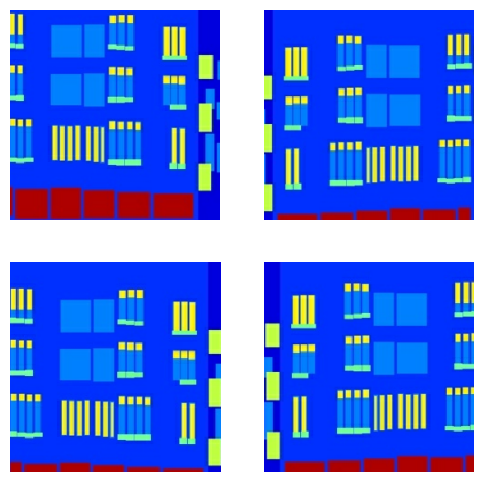

In [10]:
plt.figure(figsize=(6,6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp,re)
    plt.subplot(2,2,i+1)
    plt.imshow(rj_inp / 255.0)
    plt.axis("off")
plt.show()

In [11]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [12]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

### Création d'un pipeline d'entrée avec tf.data

In [13]:
train_dataset = tf.data.Dataset.list_files(dataset_name+"/train/*.jpg")
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [14]:
try:
    test_dataset = tf.data.Dataset.list_files(dataset_name+"/test/*.jpg")
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(dataset_name+"/val/*.jpg")
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Création du modèle (U-Net modifié)

In [15]:
from keras import Sequential, layers, Model

OUTPUT_CHANNELS = 3

# Sous-échantillonneur (étape down du U-Net)
def downsample(filters, kernel_size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.,0.02)
    """
    Les poids du noyau de la couche conv2d suivent une loi normale N(0,0.02)
    L'initialisation aléatoire permet d'éviter que les neurones aient les mêmes valeurs au départ
    Cela permet de limiter les problèmes de symétrie dans l'entrainement
    """

    model = Sequential()

    model.add(layers.Conv2D(filters,kernel_size,strides=2,padding="same",
                      kernel_initializer=initializer,use_bias=False))
    # stride=2 : divise par 2 la taille de l'image de sortie par rapport à l'image d'entrée
    # padding=same : l'image de sortie aura la même taille (ou presque) que l'image d'entrée
    # Ce résultat s'obtient en ajoutant des 0 autour de l'image si nécessaire

    if apply_batchnorm:
        model.add(layers.BatchNormalization())
    
    model.add(layers.LeakyReLU())

    return model

down_model = downsample(3,4)
down_result = down_model(tf.expand_dims(inp,0))
print("Downsampling result: ", down_result.shape)

# Suréchantillonneur
def upsample(filters, kernel_size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.02)

    model = Sequential()
    model.add(layers.Conv2DTranspose(filters,kernel_size,strides=2,padding="same",
                                     kernel_initializer=initializer,use_bias=False))
    model.add(layers.BatchNormalization())

    if apply_dropout:
        model.add(layers.Dropout(0.5))
    
    model.add(layers.ReLU())

    return model

up_model = upsample(3,4)
up_result = up_model(down_result)
print("Upsampling result:", up_result.shape)

I0000 00:00:1733907296.094947     920 cuda_dnn.cc:529] Loaded cuDNN version 90300


Downsampling result:  (1, 128, 128, 3)
Upsampling result: (1, 256, 256, 3)


In [16]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64,4,apply_batchnorm=False),
        downsample(128,4),
        downsample(256,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4)    
    ]

    up_stack = [
        upsample(512,4, apply_dropout=True),
        upsample(512,4, apply_dropout=True),
        upsample(512,4, apply_dropout=True),
        upsample(512,4),
        upsample(256,4),
        upsample(128,4),
        upsample(64,4)
    ]

    initializer = tf.random_normal_initializer(0,0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS,4,strides=2,padding="same",
                                  kernel_initializer=initializer,
                                  activation="tanh")
    
    x = inputs
    # Sous-échantillonnage
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Sur-échantillonnage
    for up, skip in zip(up_stack,skips):
        x = up(x)
        x = layers.Concatenate()([x,skip])

    x = last(x)

    return Model(inputs, outputs=x)





### Visualisation de l'architecture du générateur

Nécessite l'installation de graphviz : https://graphviz.gitlab.io/download/ et de la librairie pydot

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


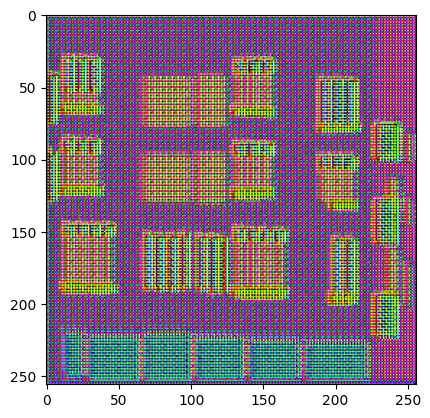

In [17]:
# %pip install pydot
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0,...])

### Définir la perte du générateur

In [18]:
from keras import losses

LAMBDA = 100
loss_object = losses.BinaryCrossentropy(from_logits=True)

In [19]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Erreur moyenne absolue
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA*l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [20]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)

    input = layers.Input(shape=[256,256,3], name="input_image")
    target = layers.Input(shape=[256,256,3], name="target_image")

    x = layers.concatenate([input,target])

    down1 = downsample(64,4,False)(x)
    down2 = downsample(128,4)(down1)
    down3 = downsample(128,4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)

    conv = layers.Conv2D(512,4,strides=1,kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)    
    
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1,4,strides=1,
                         kernel_initializer=initializer)(zero_pad2)
    
    return Model(inputs=[input,target], outputs=last)

In [21]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

### Test du discriminateur

In [22]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap="RdBu_r")
plt.colorbar()

### Définir la perte du discriminateur

In [23]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output),disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

### Définir les optimiseurs et un économiseur de points de contrôle

In [24]:
from keras import optimizers
generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Générer des images

In [25]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ["input image", "ground truth", "predicted image"]

    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]* 0.5 + 0.5)
        plt.axis("off")
    plt.show()

In [26]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

2024-12-11 09:54:59.673556: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Entrainement

In [27]:
log_dir = "logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%d-%m-%Y - %H:%M:%S"))

@tf.function()
def train_step(input_image,target,step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image,target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, 
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                            discriminator.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar("gen_total_loss", gen_total_loss, step=step//1000)
        tf.summary.scalar("gen_gan_loss", gen_gan_loss, step=step//1000)
        tf.summary.scalar("gen_l1_loss", gen_l1_loss, step=step//1000)
        tf.summary.scalar("disc_loss", disc_loss, step=step//1000)


In [28]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)
            if step != 0:
                print(f"Temps pour 1000 itérations : {time.time()-start:.2f} secondes")

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Etape d'entrainement
        if (step+1)%10 == 0:
            print('.', end="", flush=True)

        # Créer un checkpoint toutes les 5000 itérations
        if(step+1)%5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [29]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Temps pour 1000 itérations : 90.89 secondes


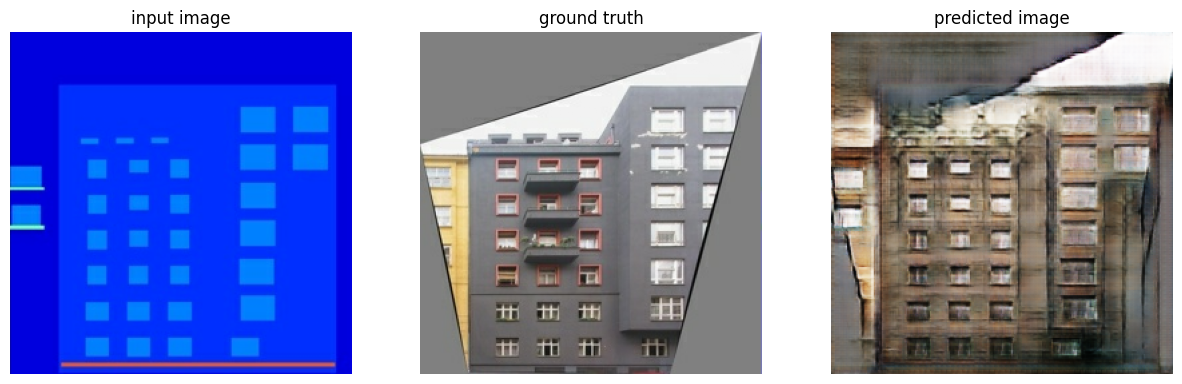

Step: 39k
....................................................................................................

2024-12-11 11:05:45.844884: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
fit(train_dataset, test_dataset, steps=40000)

In [39]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

In [40]:
%ls {checkpoint_dir}
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

checkpoint                  ckpt-5.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-5.index
ckpt-1.index                ckpt-6.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-6.index
ckpt-2.index                ckpt-7.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-7.index
ckpt-3.index                ckpt-8.data-00000-of-00001
ckpt-4.data-00000-of-00001  ckpt-8.index
ckpt-4.index


### Générer des images à l'aide du jeu de test

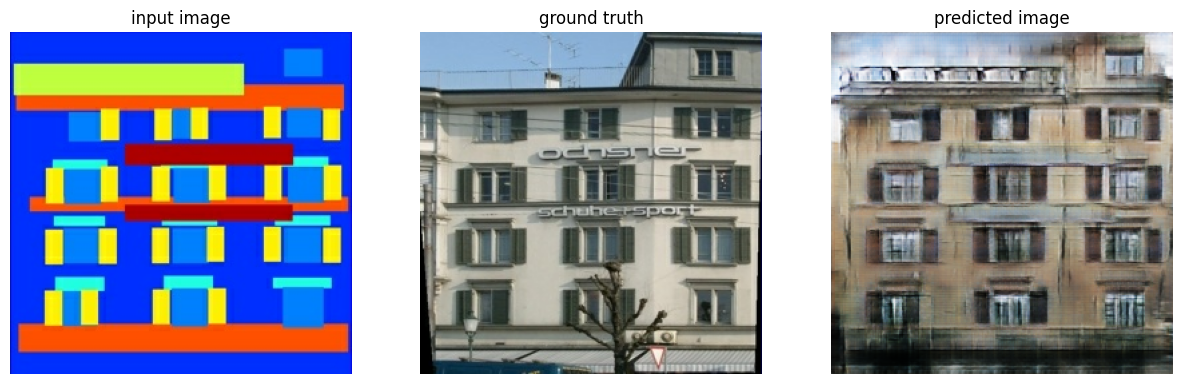

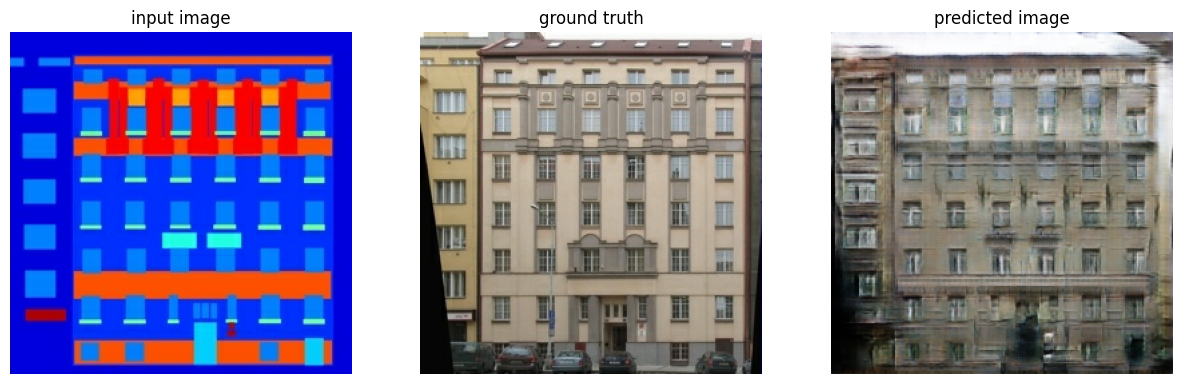

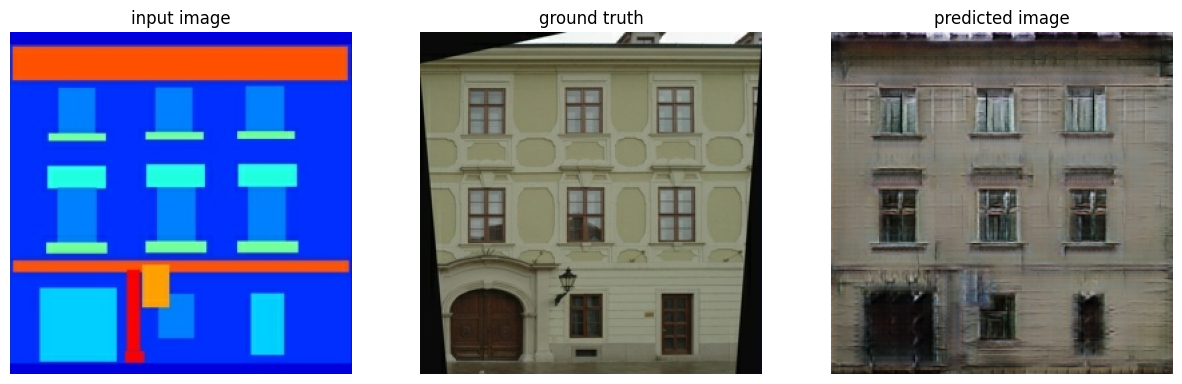

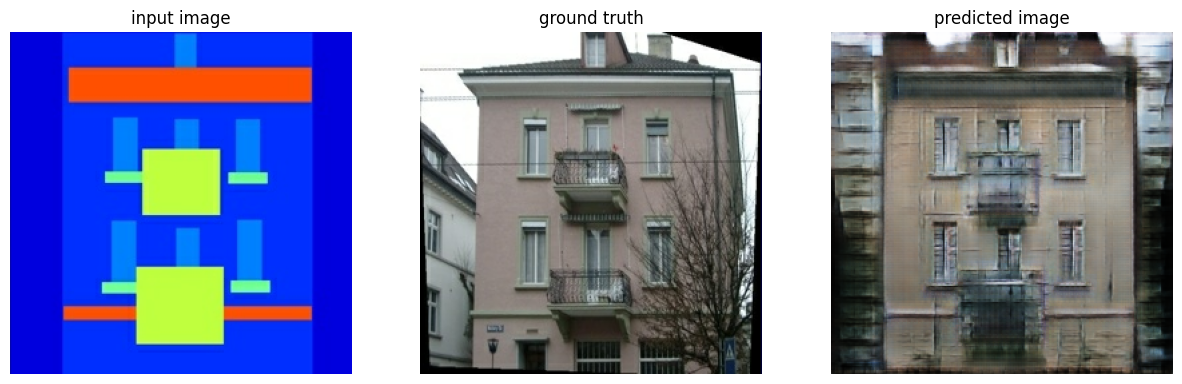

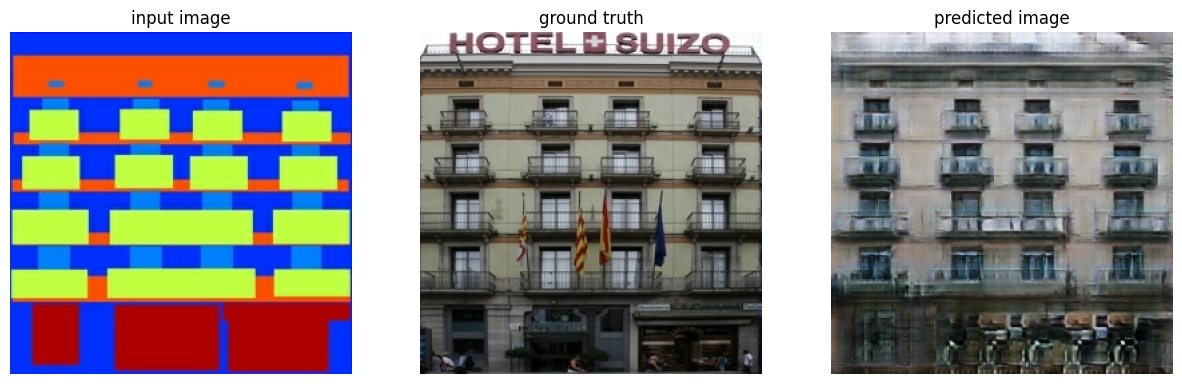

In [41]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)